# Introduction

Heart arrhythmia detector with Deep Learning is quite fascinating especially with emergence of wearable products (e.g. Apple Watch and portable EKG machines) that are capable of monitoring your heart while at home. Here we will use an ECG signal (continuous electrical measurement of the heart) and train three sequenntial deep learning models to predict heart arrythmias: dense neural network, CNN, and LSTM.  

# Dataset

We will use the MIH-BIH Arrythmia dataset from https://physionet.org/content/mitdb/1.0.0/. This is a dataset with 48 half-hour two-channel ECG recordings measured at 360 Hz. The recordings have annotations from cardiologists for each heart beat. The symbols for the annotations can be found at https://archive.physionet.org/physiobank/annotations.shtml

# Project Definition

Predict if a heart beat from the first ECG signal has an arrhythmia for each 6 second window centered on the peak of the heart beat. 

To simplify the problem, we will assume that a QRS detector is capable of automatically identifying the peak of each heart beat. We will ignore any non-beat annotations and any heart beats in the first or last 3 seconds of the recording due to reduced data. We will use a window of 6 seconds so we can compare the current beat to beats just before and after. This decision was based after talking to a physician who said it is easier to identify if you have something to compare it to. 

# Data Preparation

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir


In [23]:
# data must be downloaded and path provided
data_path = 'mit-bih-arrhythmia-database-1.0.0/'


In [24]:
# list of patients
pts = ['100','101','102','103','104','105','106','107',
       '108','109','111','112','113','114','115','116',
       '117','118','119','121','122','123','124','200',
       '201','202','203','205','207','208','209','210',
       '212','213','214','215','217','219','220','221',
       '222','223','228','230','231','232','233','234']

Here we will use a pypi package wfdb for loading the ecg and annotations.  

In [25]:
import wfdb

Let's load all the annotations and see the distribution of heart beat types across all files. 

In [26]:
df = pd.DataFrame()

for pt in pts:
    file = data_path + pt
    annotation = wfdb.rdann(file, 'atr')
#     attrs = vars(annotation)
#     print(', '.join("%s: %s" % item for item in attrs.items()))
    sym = annotation.symbol
#     print(sym)
    
    values, counts = np.unique(sym, return_counts=True)
#     print([pt])
    df_sub = pd.DataFrame({'sym':values, 'val':counts, 'pt':[pt]*len(counts)})
    df = pd.concat([df, df_sub],axis = 0)
#     print(df_sub.head())

In [27]:
df.groupby('sym').val.sum().sort_values(ascending = False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [28]:
# list of nonbeat and abnormal
nonbeat = ['[','!',']','x','(',')','p','t','u','`',
           '\'','^','|','~','+','s','T','*','D','=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

In [29]:
# break into normal, abnormal or nonbeat
df['cat'] = -1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal), 'cat'] = 1
# print(df.head())

In [30]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

Let's write a function for loading a single patient's signals and annotations. Note the annotation values are the indices of the signal array. 

In [31]:
def load_ecg(file):
    # load the ecg
    # example file: 'mit-bih-arrhythmia-database-1.0.0/101'
    
    # load the ecg
    record = wfdb.rdrecord(file)
#     print(record)
#     attrs = vars(record)
#     print(', '.join("%s: %s" % item for item in attrs.items()))
    # load the annotation
    annotation = wfdb.rdann(file, 'atr')
#     attrs = vars(annotation)
#     print(', '.join("%s: %s" % item for item in attrs.items()))
    # extract the signal
    p_signal = record.p_signal
    
    # verify frequency is 360
    assert record.fs == 360, 'sample freq is not 360'
    
    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    
    return p_signal, atr_sym, atr_sample 

Let's check out what abnormal beats are in a patient's ecg:

In [32]:
file = data_path + pts[0]

In [33]:
p_signal, atr_sym, atr_sample = load_ecg(file)
# print(p_signal)
# print(atr_sym)
# print(atr_sample)

In [34]:
values, counts = np.unique(atr_sym, return_counts=True)
for v,c in zip(values, counts):
    print(v,c)

+ 1
A 33
N 2239
V 1


Let's make a plot of these, zooming in on one of the abnormal beats

In [35]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [36]:
x = np.arange(len(p_signal))
print(x)

[     0      1      2 ... 649997 649998 649999]


65712 67872


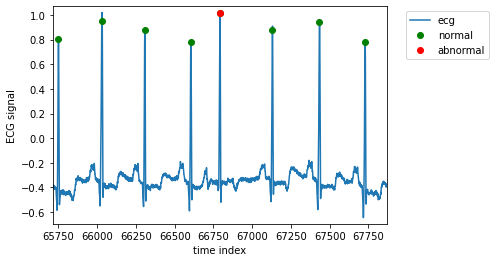

In [53]:
left = ab_index[1]-1080
right = ab_index[1]+1080
print(left, right)

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg',)
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label ='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1), loc = 'upper left')
plt.show()

# Make a dataset

Let's make a dataset that is centered on beats with +- 3 seconds before and after. 

In [54]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
#     print(np.shape(X_all))
#     print(np.shape(Y_all))
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
#         print(p_signal)
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        #print(df_ann)
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
#         print(p_signal)
#         print(df_ann,'\n\n')
#         print(num_cols)
#         print(abnormal)
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        
        num_rows = len(df_ann)

        X = np.zeros((num_rows, num_cols))
        Y = np.zeros((num_rows,1))
        sym = []
    
        # keep track of rows
        max_row = 0

        for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

            left = max([0,(atr_sample - num_sec*fs) ])
            right = min([len(p_signal),(atr_sample + num_sec*fs) ])
            x = p_signal[left: right]
            if len(x) == num_cols:
                X[max_row,:] = x
                Y[max_row,:] = int(atr_sym in abnormal)
                sym.append(atr_sym)
                max_row += 1
        X = X[:max_row,:]
        Y = Y[:max_row,:]
#         print(np.shape(X),'\n\n')
#         print(X,'\n\n')
#         print(np.shape(Y),'\n\n')
#         print(Y,'\n\n')
#         print(len(sym),'\n\n')
#         print(sym,'\n\n')
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all


Let's start by processing all samples.

In [55]:
num_sec = 3
fs = 360

In [103]:
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs, abnormal)

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, Y_all, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_train)

(73096, 2160) (73096, 1)
(36003, 2160) (36003, 1)
[[-0.47  -0.47  -0.49  ... -0.27  -0.27  -0.26 ]
 [-1.04  -1.025 -1.025 ... -0.99  -1.    -1.   ]
 [-0.74  -0.775 -0.785 ... -0.355 -0.355 -0.355]
 ...
 [ 0.05   0.05   0.035 ... -0.385 -0.39  -0.395]
 [ 0.1    0.34   0.615 ...  0.08   0.31   0.59 ]
 [-0.095 -0.16  -0.225 ...  0.13   0.1    0.1  ]]


Now we are ready to build our first dense NN. We will do this in Keras for simplicity. 

In [100]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical

In [101]:
# build the same model
# lets test out relu (a different activation function) and add drop out (for regularization)
model = Sequential()
model.add(Dense(16, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(rate = 0.30))
model.add(Dense(1, activation = 'sigmoid'))

In [102]:
# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                34576     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 34,593
Trainable params: 34,593
Non-trainable params: 0
_________________________________________________________________


In [62]:
history = model.fit(X_train, y_train, validation_data=(X_valid,y_valid), batch_size = 32, epochs= 5, verbose = 1)

Epoch 1/5
2285/2285 [==============================] - 3s 1ms/step - loss: 0.2927 - accuracy: 0.8812 - val_loss: 0.1629 - val_accuracy: 0.9466
Epoch 2/5
2285/2285 [==============================] - 2s 820us/step - loss: 0.2103 - accuracy: 0.9237 - val_loss: 0.1395 - val_accuracy: 0.9545
Epoch 3/5
2285/2285 [==============================] - 2s 797us/step - loss: 0.1882 - accuracy: 0.9342 - val_loss: 0.1333 - val_accuracy: 0.9585
Epoch 4/5
2285/2285 [==============================] - 2s 813us/step - loss: 0.1768 - accuracy: 0.9367 - val_loss: 0.1444 - val_accuracy: 0.9545
Epoch 5/5
2285/2285 [==============================] - 2s 799us/step - loss: 0.1714 - accuracy: 0.9396 - val_loss: 0.1278 - val_accuracy: 0.9613


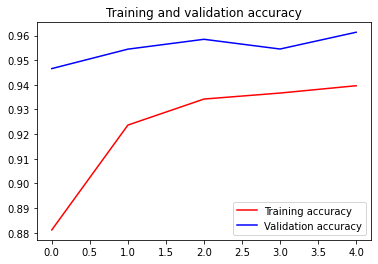

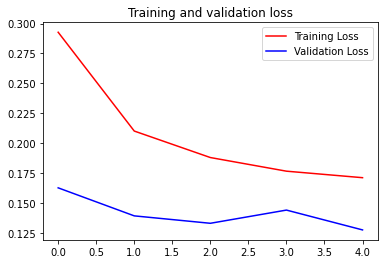

In [63]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **To show  how Overfitting can be reduced by increased dataset**

Given the overfitting between training and validation. Let's make a simple learning curve to see if we should go collect more data. 

For 10 samples


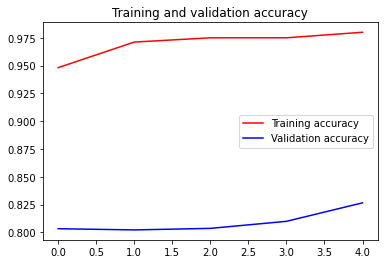

Notice..... there is reduction in the overfitting in the accuracy plot


For 20 samples


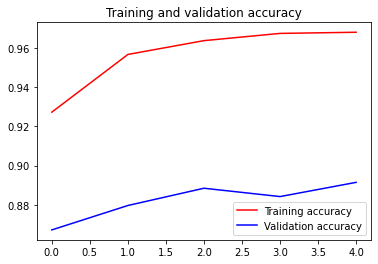

Notice..... there is reduction in the overfitting in the accuracy plot


For 30 samples


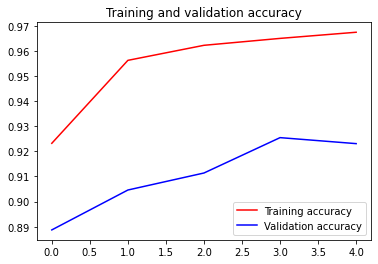

Notice..... there is reduction in the overfitting in the accuracy plot


For 48 samples


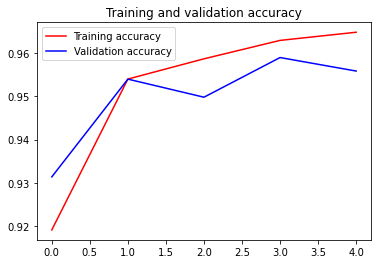

Notice..... there is reduction in the overfitting in the accuracy plot




In [104]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
aucs_train = []
aucs_valid = []

n_pts = [10,20,30,48]
for n_pt in n_pts:
    
    print('For '+ str(n_pt) + ' samples')
    pts_sub = pts_train[:n_pt]
    X_sub, y_sub, sym_sub = make_dataset(pts_sub, num_sec, fs,abnormal)

    # build the same model
    # lets test out relu (a different activation function) and add drop out (for regularization)
    model = Sequential()
    model.add(Dense(32, activation = 'relu', input_dim = X_train.shape[1]))
    model.add(Dropout(rate = 0.25))
    model.add(Dense(1, activation = 'sigmoid'))

    # compile the model - use categorical crossentropy, and the adam optimizer
    model.compile(
                    loss = 'binary_crossentropy',
                    optimizer = 'adam',
                    metrics = ['accuracy'])
    history = model.fit(X_sub, y_sub, validation_data=(X_valid,y_valid), batch_size = 32, epochs= 5, verbose = 0)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.show()
    
    print('Notice..... there is reduction in the overfitting in the accuracy plot\n\n')

More data appears to add extra value to the model. 

# Trying out different variants of Sequential Model

## One Dimensional CNN Model

Here we try with a 1 dimensional CNN as opposed to the 2D CNN for Computer vision. 

In [82]:
# reshape input to be [samples, time steps, features = 1]
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_cnn = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

print(X_train_cnn.shape)
print(X_valid_cnn.shape)


(73096, 2160, 1)
(36003, 2160, 1)


In [83]:
from keras.layers import Conv1D

In [87]:
model = Sequential()
model.add(Conv1D(filters = 64, kernel_size = 5, activation = 'relu', input_shape = (2160,1)))
model.add(Dropout(rate = 0.3))
model.add(Flatten())
model.add(Dense(1, activation = 'sigmoid'))

# compile the model - use categorical crossentropy, and the adam optimizer
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

In [88]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2156, 64)          384       
_________________________________________________________________
dropout_21 (Dropout)         (None, 2156, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 137984)            0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 137985    
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


In [89]:
history = model.fit(X_train_cnn, y_train, validation_data=(X_valid_cnn, y_valid), batch_size = 32, epochs= 2, verbose = 1)

Epoch 1/2
2285/2285 [==============================] - 167s 73ms/step - loss: 0.2185 - accuracy: 0.9233 - val_loss: 0.2145 - val_accuracy: 0.9300
Epoch 2/2
2285/2285 [==============================] - 166s 73ms/step - loss: 0.1335 - accuracy: 0.9586 - val_loss: 0.1232 - val_accuracy: 0.9637


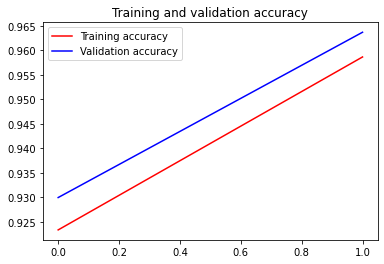

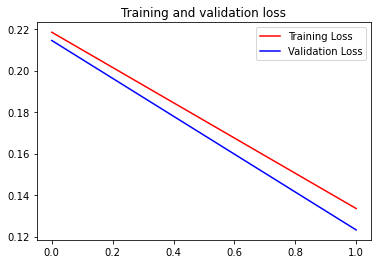

In [90]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r-', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r-', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## LSTM

In [91]:
from keras.layers import Bidirectional, LSTM

In [96]:
model = Sequential()
model.add(Bidirectional(LSTM(32, input_shape=(X_train_cnn.shape[1], X_train_cnn.shape[2]))))
model.add(Dropout(rate = 0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(
                loss = 'binary_crossentropy',
                optimizer = 'adam',
                metrics = ['accuracy'])

Let's reduce the data samples to 10000

In [97]:
history = model.fit(X_train_cnn[:10000], y_train[:10000], validation_data=(X_valid_cnn[:10000], y_train[:10000]), batch_size = 32, epochs= 1, verbose = 1)

313/313 [==============================] - 157s 502ms/step - loss: 0.6169 - accuracy: 0.6923 - val_loss: 0.6316 - val_accuracy: 0.6699


In [98]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 64)                8704      
_________________________________________________________________
dropout_24 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 65        
Total params: 8,769
Trainable params: 8,769
Non-trainable params: 0
_________________________________________________________________


**Congratulation !!**. You have now learnt how to bulid sequential deep learning models fro processing time-series data.... **Hurray**